# IBM Capstone Project: The Battle of the Neighborhoods



## Open new Arabic Restaurant in Paris, France

### Introduction
In this project, I will determine which place is good for opening Arabic Restaurant in Paris, France

- I will convert address data into their equivalent latitude and longitude values.
- For Paris neighborhood data, I will use wikipedia , https://en.wikipedia.org/wiki/Category:Districts_of_Paris
- I will use the Foursquare API to explore Paris neighborhoods and to get venues in neighborhoods.
- I will try to use the Foursquare API to get venue ratings and likes in neighborhoods (depending if there is rating available)
- I will use the k-means clustering and Agglomerative algorithms to complete clustering task
- I will use the Folium library to visualize the neighborhoods, venues , clusters in Paris


### Table of Contents
- 1. Download and Explore Neigborhood Dataset
- 2. Load and Analyze Venues of Neighborhoods in Paris
- 3. Cluster Neighborhoods using Agglomerative Clustering
- 4. Discussion
- 5. Conclusion

### 1. Download and Explore Neigborhood Dataset

#### Import Libraries

In [130]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests
print('Libraries imported.')

Libraries imported.


####  Get coordinates of Paris, France

In [189]:
# get coordinates of Paris
Paris_address = 'Paris, France'

geolocator = Nominatim(user_agent="Paris_explorer")
location = geolocator.geocode(Paris_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geographical coordinate of {} are {}, {}.'.format(Paris_address, latitude, longitude))

The geographical coordinate of Paris, France are 48.8566969, 2.3514616.


#### Get neighborhood data of Paris

I used wikiPedia, "Category:Districts of Paris" for getting neighborhoods of Paris .

In [47]:

# Read Paris neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts_of_Paris"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Paris',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], Paris_address))

There are 31 neighborhoods in Paris, France


#### Get geographical coordinates of neighborhoods

I use python geocoder library to get geograpical coordinates of neighborhoods

In [199]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,Paris_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Latitude,Longitude
0,Historical quarters of Paris,48.85717,2.34140
1,Revolutionary sections of Paris,48.85717,2.34140
2,Batignolles,48.88333,2.31667
3,Belleville,48.87018,2.38423
4,Bercy,48.83488,2.38459


#### Create Paris map with neighborhoods superimposed

Let's see locations of neighborhoods on map. In here, I use folium library to draw map

In [203]:
#create map of Paris neighborhoods using latitude and longitude values
map_Paris= folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Paris)  
    
map_Paris

### 2. Load Venues and Analyze Neighborhoods in Paris

We will use Foursquare API for getting venues of neighborhoods

#### Explore Venues of Paris neighborhoods

I get venue list with 1 km distance to neighborhood's center

In [76]:
CLIENT_ID = 'UTFZJBJO30FOFEEOHN3JRCRTFHG5FEH1LPPGVNRH4AMOIOVH' # your Foursquare ID
CLIENT_SECRET = 'FTVGBUQJXBLVX4NGKPANLRBGIVLXQMTXHJQHD2KFTD4RLTWS' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UTFZJBJO30FOFEEOHN3JRCRTFHG5FEH1LPPGVNRH4AMOIOVH
CLIENT_SECRET:FTVGBUQJXBLVX4NGKPANLRBGIVLXQMTXHJQHD2KFTD4RLTWS


In [146]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 225 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Historical quarters of Paris,48.85717,2.3414,Chez Nous,53568d3e498e92e5a3a56f36,48.855823,2.340271,171,Wine Bar
1,Historical quarters of Paris,48.85717,2.3414,Place Dauphine,4adcda09f964a520eb3321e3,48.856640,2.342362,91,Plaza
2,Historical quarters of Paris,48.85717,2.3414,Ze Kitchen Galerie,4b4b6fe4f964a520a19b26e3,48.855101,2.341297,230,Restaurant
3,Historical quarters of Paris,48.85717,2.3414,Monnaie de Paris,4adcda0ef964a520353521e3,48.856833,2.339058,175,Museum
4,Historical quarters of Paris,48.85717,2.3414,Guy Savoy,5540b49d498e84ce71f6b0ce,48.857085,2.338807,190,French Restaurant


In [147]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
French Restaurant,277
Hotel,104
Italian Restaurant,92
Bar,79
Bakery,58
Bistro,52
Plaza,51
Pizza Place,43
Japanese Restaurant,41


#### Filter restaurants out of all venues

Let's filter venues and get only restaurants

In [213]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
arabic_restaurant_list = ['Lebanese Restaurant', 'Middle Eastern Restaurant', 'Arabian Restaurant', 'Moroccan Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
arabic_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(arabic_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(arabic_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Arabic restaurants:', len(arabic_restaurants['VenueId'].unique()))
print('Percentage of Arabic restaurants: {:.2f}%'.format(len(arabic_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 777
Total number of Arabic restaurants: 22
Percentage of Arabic restaurants: 2.83%


10 neighborhoods do not have any Arabic restaurant


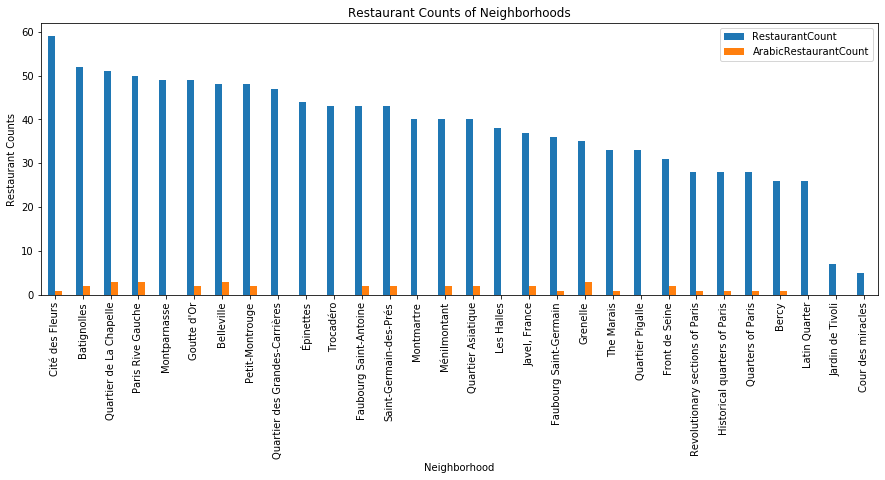

In [214]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_arabic_rest_counts =  arabic_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "ArabicRestaurantCount"})[['ArabicRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(arabic_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_arabic_rest_counts = df_arabic_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'ArabicRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_arabic_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_arabic_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Arabic restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount', 'ArabicRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

We can see from the Graph :

- Cite des Fleurs is the neihgborhood having most restaurants
- Montparnasse, Quartier des Grandes, Epinettes and Trocadero have lots of restaurants , but no single Arabic restaurant
- Jardin de Tvoli and Cour des miracles are neihgborhoods having least number of restaurants
- 10 neihgborhoods do not have any Arabic restaurant. we can choose one of these to open resaturant. To filter more let's continue

#### Show ditribution of Arabic restaurants

Let's crete a map showing ditribution of arabic restaurants and try to extract some meaningfull info from that. Also, let's show borders of Paris on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Paris center



In [205]:
Paris_center = [latitude, longitude]
map_restaurant= folium.Map(location=Paris_center, zoom_start=12)
df_neighborhood_noarabic = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_Paris) 
folium.Marker(Paris_center).add_to(map_restaurant)
folium.Circle(Paris_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(Paris_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(Paris_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(Paris_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(arabic_restaurants['VenueLatitude'], arabic_restaurants['VenueLongitude'], arabic_restaurants['Neighborhood'], arabic_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       

map_restaurant

From the map , we can see that there are

- Many restaurants in 4 km to the center
- Enough restaurants between 4-6 km to the center
- There are not any Arabic restaurants after 6 km to center
- It looks hard to find location from this view as resturant is scattered
- better maybe to filter by neighborhood and look for better chance


#### Show neighborhoods which has no Arabic restaurant on head map

Green markers are Neigborhoods without any arabic restaurants

In [221]:
Paris_center = [latitude, longitude]
map_restaurant= folium.Map(location=Paris_center, zoom_start=12)

df_neighborhood_noarabic = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_Paris) 
#HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_Paris)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noarabic['Latitude'], df_neighborhood_noarabic['Longitude'], df_neighborhood_noarabic['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

### 3. Cluster Neigborhoods using Agglomerative Clustering

In [175]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

30  neighborhoods' venue category are shown in 225 columns as below


,Neighborhood,Wine Bar,Plaza,Restaurant,Museum,French Restaurant,Coffee Shop,Park,Church,Bridge,Hotel,Cocktail Bar,Wine Shop,Theater,Pedestrian Plaza,Art Gallery,Exhibit,Asian Restaurant,Lebanese Restaurant,Cosmetics Shop,Bar,Clothing Store,Ramen Restaurant,Sandwich Place,Bookstore,Tapas Restaurant,Breton Restaurant,Art Museum,Burger Joint,Bistro,Seafood Restaurant,Ice Cream Shop,Italian Restaurant,Liquor Store,Pub,Historic Site,Chinese Restaurant,Flower Shop,Pizza Place,Pastry Shop,Chocolate Shop,Bakery,Jazz Club,Creperie,Beer Bar,Arts & Crafts Store,Toy / Game Store,Electronics Store,Alsatian Restaurant,Tea Room,Cajun / Creole Restaurant,Gym / Fitness Center,Farmers Market,Bagel Shop,Modern European Restaurant,Steakhouse,Indian Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Thai Restaurant,Basque Restaurant,Japanese Restaurant,Korean Restaurant,Turkish Restaurant,History Museum,Mediterranean Restaurant,BBQ Joint,Corsican Restaurant,Noodle House,Indie Movie Theater,Brasserie,Diner,Sushi Restaurant,Concert Hall,Cheese Shop,African Restaurant,Hostel,Thrift / Vintage Store,Vietnamese Restaurant,Gastropub,Café,Moroccan Restaurant,Spanish Restaurant,Dessert Shop,Street Food Gathering,Music Venue,Rock Club,Juice Bar,Dim Sum Restaurant,Ethiopian Restaurant,Comedy Club,Beer Store,Brewery,Kebab Restaurant,Vegetarian / Vegan Restaurant,Record Shop,Sporting Goods Shop,Mexican Restaurant,Shopping Plaza,Department Store,Multiplex,Miscellaneous Shop,Lounge,Garden,Performing Arts Venue,Recording Studio,Beer Garden,Candy Store,Portuguese Restaurant,Pool,Comic Shop,Food Truck,Skate Park,Furniture / Home Store,Nightclub,Breakfast Spot,Flea Market,Trail,Garden Center,Kitchen Supply Store,Health Food Store,Grocery Store,Supermarket,Perfume Shop,Road,Brazilian Restaurant,Cultural Center,Fast Food Restaurant,Doner Restaurant,Greek Restaurant,American Restaurant,Athletics & Sports,Metro Station,Bus Line,Harbor / Marina,Tram Station,Bank,Argentinian Restaurant,Scenic Lookout,Comfort Food Restaurant,Auvergne Restaurant,Market,Belgian Restaurant,Cambodian Restaurant,Playground,Gourmet Shop,Fountain,Cupcake Shop,Hookah Bar,Food & Drink Shop,Dance Studio,Savoyard Restaurant,Pop-Up Shop,Opera House,Butcher,Soup Place,Camera Store,Falafel Restaurant,Resort,Southwestern French Restaurant,Gluten-free Restaurant,Peruvian Restaurant,Shoe Store,Sculpture Garden,Boat or Ferry,Tailor Shop,Men's Store,Shopping Mall,Island,Outdoor Sculpture,Persian Restaurant,Radio Station,Bike Rental / Bike Share,Library,Hotel Bar,Film Studio,Scandinavian Restaurant,Irish Pub,Convenience Store,Israeli Restaurant,Gym,Bus Stop,Baby Store,Tattoo Parlor,Martial Arts School,Taco Place,Fried Chicken Joint,Fabric Shop,Monument / Landmark,Botanical Garden,Spa,Science Museum,Zoo,Caucasian Restaurant,Salad Place,Women's Store,Souvlaki Shop,Udon Restaurant,Bubble Tea Shop,Music Store,Fish & Chips Shop,Okonomiyaki Restaurant,Provençal Restaurant,Gay Bar,Deli / Bodega,Paper / Office Supplies Store,Speakeasy,Cemetery,Street Art,Vineyard,Gift Shop,Arepa Restaurant,Planetarium,Fish Market,Soccer Field,Discount Store,Szechuan Restaurant,Pharmacy,Boutique,New American Restaurant,Antique Shop,Basketball Court,Theme Park Ride / Attraction,Champagne Bar,Beach Bar,Arts & Entertainment
0,Batignolles,5,0,5,0,20,2,3,0,0,6,0,1,0,0,0,0,0,1,0,5,0,0,0,2,0,0,1,1,0,0,1,8,1,1,0,0,0,2,3,0,2,0,1,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Belleville,3,0,4,0,10,3,1,0,0,0,3,0,1,0,0,0,1,0,0,19,0,0,0,1,0,0,1,2,3,0,0,3,0,0,0,1,0,4,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0,2,1,1,2,1,3,3,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [176]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Batignolles,100,French Restaurant,Italian Restaurant,Hotel,Wine Bar,Bar,Restaurant,Park,Pastry Shop,Turkish Restaurant,Japanese Restaurant
1,Belleville,100,Bar,French Restaurant,Pizza Place,Restaurant,Wine Bar,Moroccan Restaurant,Café,Bistro,Cocktail Bar,Italian Restaurant
2,Bercy,100,French Restaurant,Italian Restaurant,Hotel,Bistro,Coffee Shop,Garden,Wine Bar,Supermarket,Food Truck,Beer Garden
3,Cité des Fleurs,100,French Restaurant,Pizza Place,Bar,Wine Bar,Restaurant,Italian Restaurant,Turkish Restaurant,Bistro,Coffee Shop,Park
4,Cour des miracles,28,Bakery,Plaza,Pizza Place,Museum,French Restaurant,Garden,Farmers Market,Bank,Tram Station,Harbor / Marina


#### Cluster and find similarities between neighborhoods

I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods


First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset

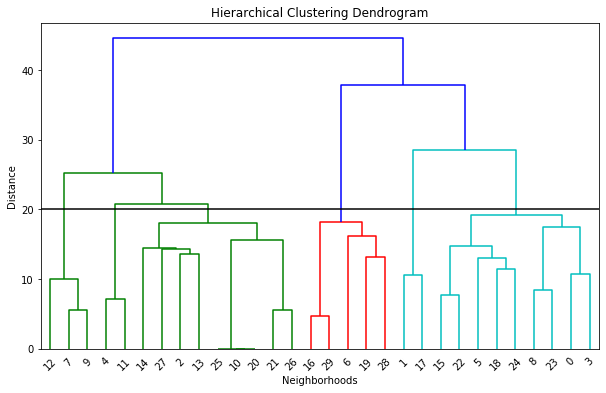

In [177]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 6 clusters (cut at distance of 20, horizontal black line). I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [180]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Historical quarters of Paris,48.85717,2.34140,1,Plaza,French Restaurant,Wine Bar
1,Revolutionary sections of Paris,48.85717,2.34140,1,Plaza,French Restaurant,Wine Bar
2,Batignolles,48.88333,2.31667,0,French Restaurant,Italian Restaurant,Hotel
3,Belleville,48.87018,2.38423,3,Bar,French Restaurant,Pizza Place
4,Bercy,48.83488,2.38459,1,French Restaurant,Italian Restaurant,Hotel


In [187]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(Paris_center).add_to(map_clusters)
folium.Circle(Paris_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(Paris_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(Paris_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(Paris_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [188]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                    
0                   French Restaurant                            9
1                   French Restaurant                            6
                    Plaza                                        3
2                   French Restaurant                            5
3                   Bar                                          2
4                   French Restaurant                            3
5                   Bakery                                       1
                    Hotel                                        1


Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Bakery                                       1
                    Bar                                          3
                    Italian Restaurant                           4
                    Pizza Place                                  1
1                   Bakery                                       1
                    Clothing Store                               1
                    French Restaurant                            3
                    Italian Restaurant                           2
                    Plaza                                        1
                    Wine Bar                                     1
2                   Hotel                                        5
3                   French Restaurant                            2
4                   Hotel                                        3
5                   French Restaurant                            1
                    Plaza                                        1

We can see cluster categories as below
- Cluster 0 (Red) : French and Italian Restaurant , Pizza, Bakery and Bar
- Cluster 1 (Purple) : French and Italian Restaurant , Clothing stores, Plaza
- Cluster 2 (BLue) : French Restaurant and Hotel 
- Cluster 3 (Cyan) : French Restaurant, Bar
- Cluster 4 (Green) : French Restaurant	and Hotel
- Cluster 5 (Orange) : Bakery and Hotel

### 4. Discussion

Cluster 4 and 5 suffers from restaurant. Especially there is very less Arabic restaurant 4-6km from center and no after 6Km from center . We can think about Cluster 4 area

Cluster 0 especially likes French tastes , may be this part will not like Arabic tastes . We can only think about 1 location may be .

Cluster 1, 2, 3 are centers full of restaurants especially French and Italian so it maybe not a good idea

### 5. Conclusion

Possible Neighborhoods to set up a Arabic restaurant :

- Montparnasse, Quartier des Grandes, Epinettes and Trocadero have lots of restaurants , but no single Arabic restaurant

- Since Montparnasse and Trocadero are the best as they located in Cluster 4 as expalined above

- Quartier des Grandes could be 2nd option to think about one location as it is located in cluster 0


# Thanks for your time reviewing my simple project